# Statistical Methods in Finance
## Final Project - Empirical Analysis of Heavy-Tails Behavior of Financial Data
### Group Members: Qixin Niu, Ye Xiao, Zuming Gao, Ruizhi Kong

In [2]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats as st
sns.set()
import scipy.interpolate as interp
import matplotlib as mlab
from numpy import log as ln
from math import pi
import math
from cmath import exp
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm
from scipy.stats import f
from scipy.special import gamma
import warnings
warnings.filterwarnings("ignore")

# 1. Introduction


The purpose of this project is to identify and test, whether the Gaussian assumption for returns is realistic on selected sample data. Many multivariate applications, such as the widely used value-at-risk (VaR), the risk measure of a certain portfolio, are still based on normally distributed random variables. However, the distributions are considered too simple and often do not capture extreme events. In order to tackle this problem, We propose statistically estimate alternatives, Stable, Pareto and Hyperbolic distributions. We discuss these models in order to shed light on the tail behaviour of the distribution of the returns. We show that, besides Gaussian distribution, which is a subset of generalised hyperbolic distributions,  another subset hyperbolic distributions, can be used for the VaR estimations with much better fits to the data.  

# 2. Overview of Existing Methodology 

### a. Normal Distribution

Given a successive daily log-losses $(L_{1}, L_{2},...,L_{n})$ of a year (252 trading days), if the distribution of the log-losses follow a Gaussian distribution, we estimate the two parameters using the sample mean $\hat{\mu}$ and sample variance $\hat{\sigma}$. 

$$\hat{\mu}=\frac{1}{n}\sum^{n}_{i=1}R_{i}$$
$$\hat{\sigma}=(\frac{1}{n-1}\sum^{n}_{i=1}(R_{i}-\hat{\mu})^{2})$$

And we calculate the $(1-\alpha)$ quantile $q^{L}_{1-\alpha}$ by extracting it from the fitted Gaussian distribution with mean $\hat{\mu}$ and variance $\hat{\sigma}$.

In [3]:
class Normal_Estimator:
    
    def __init__(self, x):
        '''
        x: array of log losses, shape n*1
        ----------------------------------------
        Return: estimated mean, standard deviation of given data
        '''
        self.x = x
        self.n = len(x)
        self.mean = 0
        self.sigma = 1
        self.fitted_var = 0
        self.empirical_var = 0
    
    def fit_normal(self):
        '''

        Return: estimated mean, standard deviation of given data
        '''
        self.mean = self.x.mean()
        self.sigma = np.sqrt(pow(self.x - self.mean, 2).sum() / (self.n - 1))
    
    def quantile(self,q):
        '''
        Return: q% quantile of the normal
        '''
        self.fitted_var = norm.ppf(q,loc=self.mean,scale=self.sigma)
        self.empirical_var = np.percentile(self.x, q * 100)
    
    def pdf(self, sample):
        '''
        sample: array of sample points
        ----------------------------------------
        Return: values of probability density function on the sample points
        '''
        y = norm.pdf(sample, self.mean, self.sigma)
        return y
        

### b. Stable Distribution

Another choice of model is stable distribution. By modifying its parameters, we can control its tail behavior and make it approximate the tail of the real dsitrbution. It is defined by following characteristic function:

\begin{equation}
\phi(x)=\left\{
\begin{aligned}
&exp[i\mu t-\sigma^{\alpha}|~t~|^{\alpha}(1-i\beta sign(t)tan(\frac{\pi \alpha}{2}))] \qquad &if\quad \alpha \neq 1\\
&exp[i\mu t-\sigma^{\alpha}|~t~|^{\alpha}(1+\frac{2}{\pi}i\beta sign(t)ln|~t~|)] \qquad &if \quad \alpha = 1
\end{aligned}
\right.
\end{equation}

When $\alpha < 2$, a stable distribution has tail behavior like a power law: $\mathbb{P}[X\leq x]\thickapprox \frac{C_{st}}{|~x~|^{\alpha}}$ when $x\rightarrow -\infty$ with $C_{st}=\sigma^{\alpha}sin(\frac{\pi \alpha}{2})\frac{\Gamma (\alpha)}{\pi}(1-\beta)$

For the stable distribution we use the function $McCullochParametersEstim()$ in the R package $fBasics$ to estimate the four parameters $\alpha,\beta,\sigma,\mu$, after which we compute the VaR estimation.


### c. Pareto Distribution

Instead of modelling the whole distribution, we can also model only the tail distribution using pareto law. Its cdf of log-losses has following expression:

$\mathbb{P}[L_{t}>x]= 1-F(x)=\frac{C}{x^{\alpha}}$ for $x>x_{0}$,

$$lnL_{(i)}=-\gamma ln(\frac{n+1-i}{n+1})+K+\epsilon_{i}$$

where $\gamma = \frac{1}{\alpha}$, $K =\gamma lnC$ is a constant and $\epsilon_{i}$ is a noise

$$\hat{\gamma}=-\frac{\sum_{i=d_{n}}^{u_{n}}ln(\frac{n+1-i}{n+1})(lnL_{(i)}-\bar{lnL})}{\sum_{i=d_{n}}^{u_{n}}ln(\frac{n+1-i}{n+1})(ln(\frac{n+1-i}{n+1}) - \bar{ln(\frac{n+1-i}{n+1}}))}$$

$\hat{C}=L^{\hat{alpha}}_{\lfloor nw \rfloor}(1-\omega)$  and  $\hat{x_{0}}=L_{\lfloor nw \rfloor}$ 

$$\hat{q^{L}_{p}}=(\frac{\hat{C}}{1-p})^{\hat{\gamma}}=L_{\lfloor nw \rfloor}(\frac{1-\omega}{1-p})^{\hat{\gamma}}$$

We estimated the pareto distribution by setting $d_{n} = \lfloor 0.95 \times n \rfloor$, $u_{n}=\lfloor 0.99 \times n \rfloor$ and $w = 0.9$, where n is the number of log-losses.

In [4]:
class Pareto_Estimator:
    
    def __init__(self, x, w):
        '''
        x: array of log losses, shape n*1
        dn: the lower bound of the closed interval, type int
        un: the upper bound of the closed interval, type int
        w: chosen as extreme level, in [0, 1]
        '''
        x.sort()
        self.x = x
        self.dn = int(len(x) * 0.95)
        self.un = int(len(x) * 0.99)
        self.w = w
        self.nw = int(len(x) * w)
        self.lnl = np.log(x)
        self.fitted_var = 0
        self.empirical_var = 0
    
    def fit_pareto(self):
        '''
        Return: estimated pareto tail index alpha, pareto constant C
        '''
        n = len(self.lnl)
        self.lnx = np.log(((n + 1) * np.ones(n) - (np.arange(n) + 1)) / (n + 1))
        
#       if it has positive quantile, say positive at 95%, move a bit
#         for i in range(self.dn - 1, n):
#             if np.isnan(self.lnl[i]) != True: 
#                 self.dn = i + 1
#                 break
            
        reg = LinearRegression().fit(-self.lnx[self.dn - 1:self.un].reshape(-1, 1),
                                     self.lnl[self.dn - 1:self.un].reshape(-1, 1)) # formula (9)
        self.gam = reg.coef_.squeeze()
        self.K = reg.intercept_ 
        self.C = pow(self.x[self.nw - 1], (1 / self.gam)) * (1 - self.w) # formula (10)
    
    def quantile(self, p):
        '''
        p: probability greater or equal to w%
        ----------------------------------------
        Return: quantile of log losses of level p, p quantile of the real data 
        '''
        if p < (self.w) or p > 1:
            raise Exception('not a vaild probability', p) 
            
        self.fitted_var = pow(self.C / (1 - p), self.gam) # formula (10)
        self.empirical_var = np.percentile(self.x, p * 100)
    
    def pareto_plot(self):
        '''
        draw pareto plot, axis-x: ln((n+1-i)/(n+1)), axis-y: Ln(L(i))
        '''
        y = self.gam * -self.lnx + self.K
        plt.figure(figsize = (6.5, 6))
        plt.plot(-self.lnx, self.lnl, linewidth=1.5, linestyle=':', label = 'scatter')
        plt.plot(-self.lnx, y, linewidth=1.5, linestyle='-', label = 'fitted line')
        plt.xlabel(r'$-ln(\frac{n+1-i}{n+1})$')
        plt.ylabel('$lnL(i)$')
        plt.legend()
        
    def pdf(self, sample):
        '''
        sample: array of sample points
        ----------------------------------------
        Return: values of probability density function on the sample points over x0
        '''
        x0 = np.percentile(self.x, self.w * 100)
        sample[sample < x0] = x0
        alpha = (1 / self.gam)
        f = lambda x :  alpha * self.C / pow(x, alpha + 1)
        vfunc = np.vectorize(f)
        return vfunc(sample)

# 3. Data Discription

The financial instruments considered in our analysis are constituents in Financial Times Stock Exchange 100 Index (FTSE 100) as of December 2017. The market data are provided by Yahoo Finance and the stocks are identified by tickers in London Stock Exchange. Out of all the constituents in FTSE 100, we selected those with completed data across the whole period from Jan 2, 2007 to Nov 30, 2018, which leads us with a subset with 45 stocks. In the following analysis, we focus on the log-returns of the end-of-day closing prices of the selected stocks.

We define the daily log-returns as follows:
\begin{align}
    r_{t}=-ln\Big(\frac{S_{t+1}}{{S_{t}}}\Big)
\end{align}
where $S_{t}, t\geq$0, is the stock price measured on days units.

In [5]:
#data.csv stores historical prices for all 45 stocks from Jan 2, 2007 to Nov 30 2018
df = pd.read_csv('data.csv', index_col = 'Date')
listExtractTickers = list(df)
nbTickers = len(listExtractTickers)
#normalized historical prices
df_norm = (df - df.mean()) / df.std()

In [6]:
print("Total number of tickers:", nbTickers)
print("Numer of rows:", len(df))

Total number of tickers: 45
Numer of rows: 3065


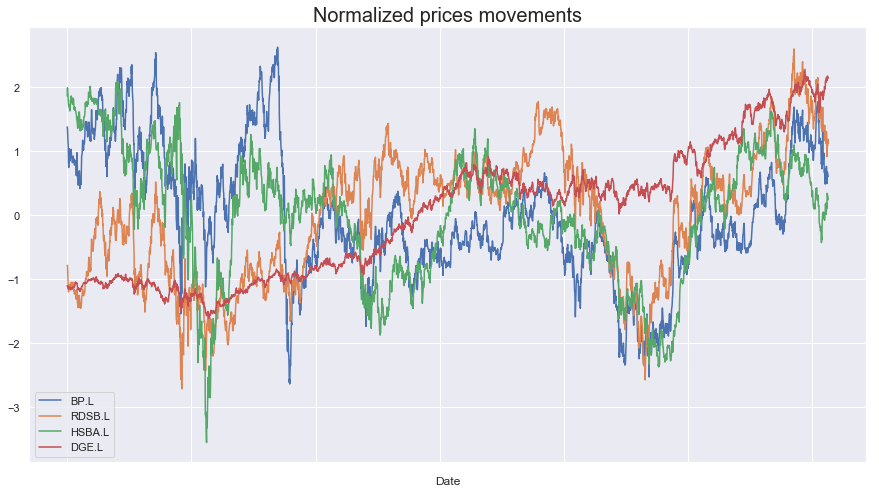

In [7]:
# Plot the normalized prices movements for the first 4 stocks
df_norm.iloc[:, :4].plot(figsize = (15, 8), linewidth = 1.5)
plt.title('Normalized prices movements', fontsize = 20);

In [8]:
# Populat daily log-returns 
log_returns = np.log(df)
log_returns = log_returns.diff().dropna()

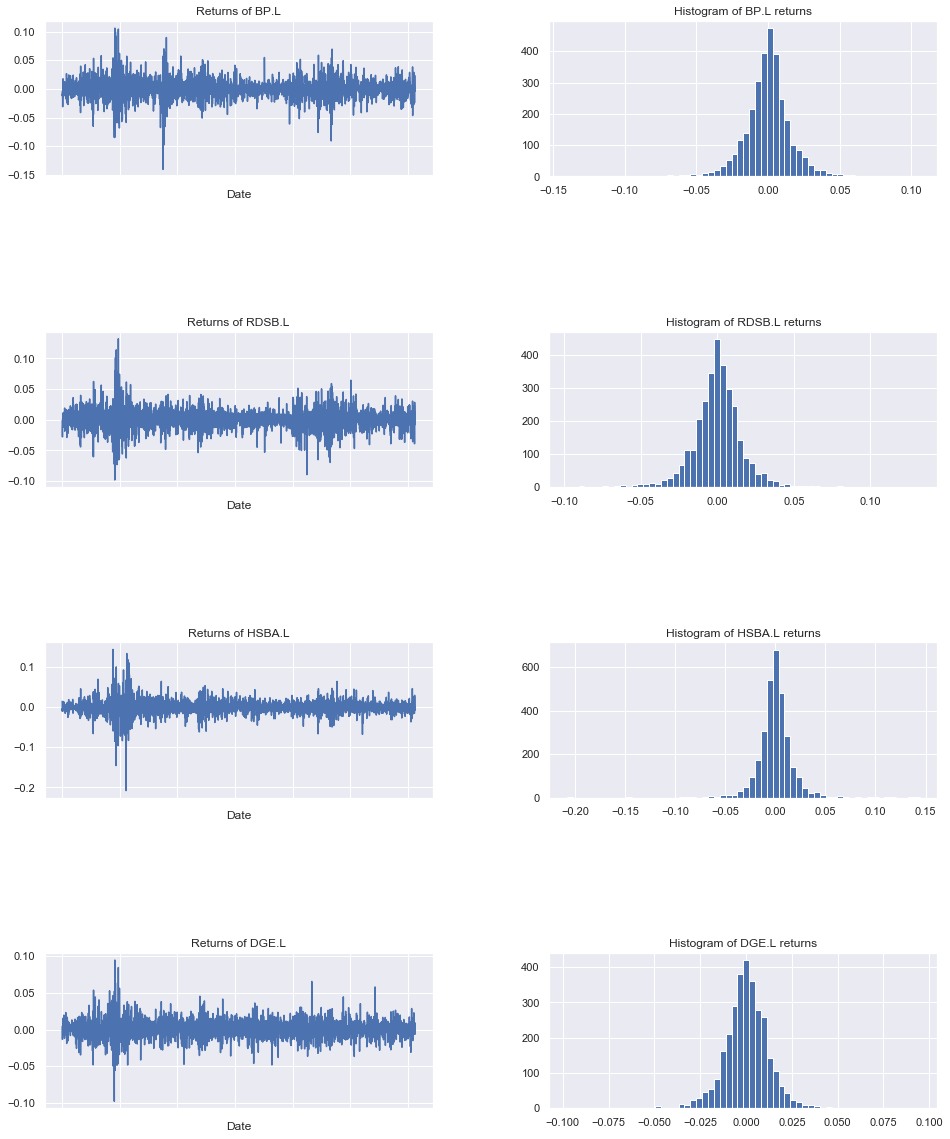

In [9]:
# Plot the log-returns and histograms for the first 4 stocks
nb = 4
fig, axs = plt.subplots(nrows=nb, ncols=2, figsize=(16, 20))

for i in range(nb):
    ticker = listExtractTickers[i]
    plt.subplot(nb, 2, 2*i+1)
    log_returns[ticker].plot()
    plt.title('Returns of %s' %ticker)
    plt.subplot(nb, 2, 2*i+2)
    log_returns[ticker].hist(bins=60)
    plt.title('Histogram of %s returns' %ticker)
    
plt.subplots_adjust(hspace=1., wspace=0.3)
plt.show()

# 4. Numerical Experiment

### Value-at-Risk (VaR)

The Value-at-Risk (VaR) is the most prominent loss-distribution-based risk measure in quantitative risk management. Though its use was popularised by JP Morgan in 1990s, the use of VaR can be traced back to late 1980s. The 1996 amendment to Basel I adopted VaR into the regulatory framework.
The theoretical intuition behind VaR is, for a fixed probability $\alpha$ (e.g. $\alpha = 0.95$), one can find a level such that the probability the loss exceeds this level is less than or equal to $1-\alpha$. [3]

__Definition:__ Let $\alpha \in (0,1)$, The Value-at-Risk (VaR) of loss L at confidence level $\alpha$ is given by

$$ VaR_{\alpha}(L):= inf \{{l\in \mathbb{R}:\textbf{P}[L>l]\leq 1-\alpha}\}$$

There are two approaches of esitimating VaR, one is parametric and the other is non-parametric. The non-parametric approach for example, historical simulation, uses only the histrical data without fitting a model. This approach might not be suitable for limitted amount of available data, as it does not provide useful results when extreme events exist. However, the parametric approach involes fitting the parameters of a model to historical data, then one can choose either numerical or analytic methods to compute the VaR.

In the following experiment, we used rolling historical simulation to estimate VaRs. We fixed a rolling window containing 252 days, and used the data in the window to forecast the VaR for the next day. Then we moved the window by one day and repeated the operations above. Keep doing this we can get a series of VaRs which could be used for later backtesting.

In [10]:
import time

class VaR:
    
    def __init__(self, x, model, alpha, windowsize):
        '''
        x: array of log losses, shape n*1
        estimator: fitted model: (1) normal; (2) Stable; (3) Paretp
        alpha: significant level
        '''
        self.x = x
        self.alpha = alpha
        self.windows = len(x) - windowsize
        self.empirical_var = []
        self.fitted_var = []
        self.windowsize = windowsize
        self.model = model
        self.tail_index = []
        self.C_st = []
    
    def get_VaR(self):
        '''
        get the VaR of given significant level and chosen model
        '''
        self.time = 0 # record the fitted time
        for i in range(self.windows):
            # print("epoch:", i)
            if self.model == "Normal":
                start = time.time()
                ne = Normal_Estimator(self.x[i:i+self.windowsize])
                ne.fit_normal()
                self.time += time.time() - start
                ne.quantile(self.alpha)
                self.fitted_var += [ne.fitted_var]
                self.empirical_var += [ne.empirical_var]
                
            elif self.model == "Pareto":
                start = time.time()
                pe = Pareto_Estimator(self.x[i:i+self.windowsize],0.8)
                pe.fit_pareto()
                self.time += time.time() - start
                pe.quantile(self.alpha)
                self.fitted_var += [pe.fitted_var]
                self.empirical_var += [pe.empirical_var]
                self.tail_index.append(1 / pe.gam)
                self.C_st.append(pe.C)
                
        self.time = self.time / self.windows

### Backtesting

To see the forecasted VaRs are precise or not, we need to do the backtesting. Here we follow the procedure in the original paper. With daily asset prices $(S_{0},...,S_{T})$ and estimated VaR with level $99\%$, we counted the number of exceedances:

\begin{equation}
J_{t+W+1}=\left\{
\begin{aligned}
&1 \quad if\quad log(S_{t+W}) - log(S_{t+W+1}) > VaR_{t+W} \\
&0 \quad otherwise
\end{aligned}
\right.
\end{equation}

We expected the proportion of total exceedances is closed to $1-\alpha$. If $VaR_{\alpha}$ is accurate, the exceedances should satisfy a Bernoulli distribution with $p=1-\alpha$. Then the sum of exceedances $\sum_{t = 0}^{T-W}J_{t+W+1}$follows a binomial distribution, by which we can calculate the confidence interval at $100 \times (1 - \kappa)\%$ using the formula in the paper:


$$\left[\frac{1}{1 + \frac{n-k+1}{k}F_{2(n-k+1),2k}(1 - \kappa/2)}, \frac{\frac{k+1}{n-k}F_{2(k+1),2(n-k)}(1 - \kappa/2)}{1+\frac{n-k+1}{k}F_{2(n-k+1),2k}(1 - \kappa/2)}\right]$$

where k in the number of exceedances, n is sample size and $F_{v_{1},v_{2}(p)}$ is the inverse of the quantile at level p of the F-distribution with degree of freedoms $v_{1}$ and $v_{2}$. If the horizontal line $1\%$ lies within the confidence interval, then we can't reject the fitted VaR is correct.

In [11]:
def Back_Testing(neg_return, VaR, cf):
    '''
    neg_return: array of log losses, shape n*1
    VaR: array of estimated Value at Risk 
    cf: level of confidence interval
    -------------------------------------------
    Return: confidence interval of the VaR
    '''
    n = len(neg_return)
    start = n - len(VaR)
    # indicator = [1 if neg_return[start + i] > VaR[i] else 0 for i in range(len(VaR))]
    indicator = []
    for i in range(len(VaR)):
        if ~np.isnan(VaR[i]):
            if neg_return[start + i] > VaR[i]: indicator.append(1)
            else: indicator.append(0)
            
    k = np.sum(indicator)
    # print("num of samples : ", n, "| num of exceedances: ", k)
    avg_por = k / len(indicator)
    f1 = f.ppf(1 - cf/2, 2 * (n - k + 1), 2 * k)
    f2 = f.ppf(1 - cf/2, 2 * (k + 1), 2 * (n - k))
    lower = 1 / (1 + (n - k + 1) * f1 / k)
    upper = ((k + 1)/(n - k)) * f2 / (1 + ((k + 1) / (n - k)) * f2)
    return lower, upper, avg_por

## a. Normal 

After looking at the data, we decided to use normal distribution to fit the data first. If normal distribution, say the most common and simplest model, already fit the data quite well, then it is not necessary to find a more complicated one. Let's try a toy asset first.

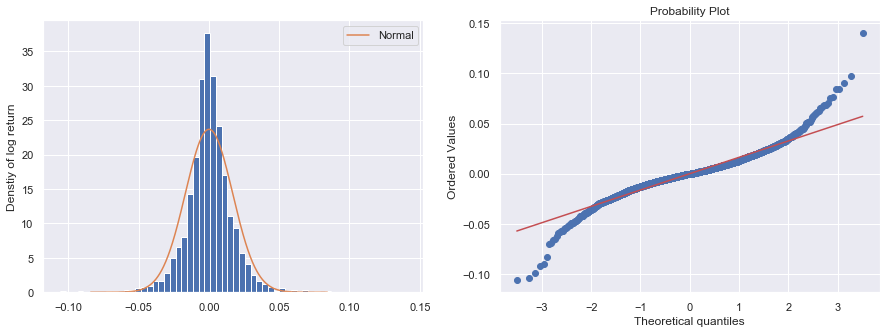

In [12]:
# pick up one stock and give a quick view
toy = -1 * np.array(log_returns['BP.L'])

# Get Normal VaR
nvar = VaR(toy,"Normal",0.99,252)
nvar.get_VaR()

# give a quick look of the fitted result
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
plt.subplot(1,2,1)
ne = Normal_Estimator(toy)
ne.fit_normal()
mu = ne.mean
sigma = ne.sigma
x = np.linspace(mu - 5 * sigma, mu + 5 * sigma, 1000)
(-1 * log_returns['BP.L']).hist(bins = 60, normed = True)
plt.plot(x, mlab.mlab.normpdf(x, mu, sigma), label= 'Normal')
plt.legend()
plt.ylabel('Denstiy of log return')

plt.subplot(1,2,2)
import scipy.stats as stats
import pylab
stats.probplot(toy, dist="norm", plot=pylab)
pylab.show()

We plot the histogram of the observed log return as well as the pdf of fitted normal distribution. Seems the fitted normal can't fullfill our expectation. The peak of empirical density dominates the normal density and the range of x-axes reflect a heavier right tail, which is more intuitive in the Q-Q plot.

Plotting the above two pictures is not enough to persuade us stop using normal distribution, thus we carried out numerical experiments on the selected 45 assets. We estimated the VaRs from the fitted normal distribution and did the backtesting using the methods mentioned above.

In [13]:
# Let's start massive data calculation!
N_VaR = []
count = 0
tic = 0
for col in log_returns:
    count += 1
    negl_return = -1 * np.array(log_returns[col])
    
    # Get Pareto VaR
    nvar = VaR(negl_return,"Normal",0.99,252)
    nvar.get_VaR()
    tic += nvar.time
    if count%5 == 0:
        print("Fitting time need for current stock: %.5f seconds" % nvar.time)
    N_VaR.append(nvar.fitted_var)
    
print("Average fitting time per stock (Normal): %.5f seconds" % (tic / nbTickers))
N_VaR = np.array(N_VaR).T # of shape N * P (stock num)

Fitting time need for current stock: 0.00002 seconds
Fitting time need for current stock: 0.00002 seconds
Fitting time need for current stock: 0.00002 seconds
Fitting time need for current stock: 0.00003 seconds
Fitting time need for current stock: 0.00002 seconds
Fitting time need for current stock: 0.00002 seconds
Fitting time need for current stock: 0.00002 seconds
Fitting time need for current stock: 0.00002 seconds
Fitting time need for current stock: 0.00002 seconds
Average fitting time per stock (Normal): 0.00002 seconds


The runtime need for fitting normal is really fast since it only only need to estimate two parameters and the calculations involved were merely simple algebra.

In [14]:
# the i-th element of n_upper is the i-th stock's upper bound of CI, the rest likewise
n_upper, n_lower, n_avgpor = np.zeros(N_VaR.shape[1]), np.zeros(N_VaR.shape[1]), np.zeros(N_VaR.shape[1])

for i in range(N_VaR.shape[1]):
    negl_return = -1 * np.array(log_returns.iloc[:, i])
    # Backtesting Pareto
    u, l, a = Back_Testing(negl_return, N_VaR[:, i], 0.01)
    n_upper[i], n_lower[i], n_avgpor[i] = u, l, a
    

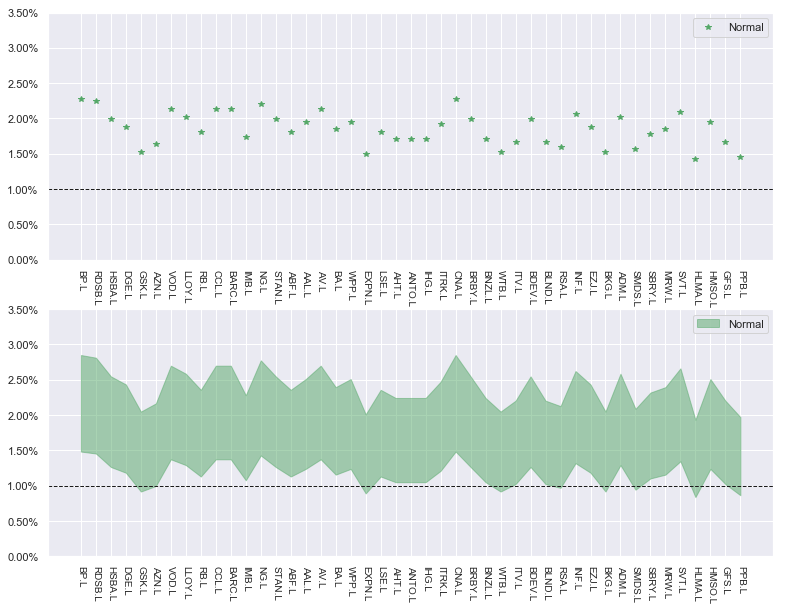

In [15]:
# draw the 99% CI of VaR given chosen stocks
import matplotlib.ticker as mtick
plt.subplots(figsize = (13, 10))
ax1 = plt.subplot(2, 1, 2)
ax1 = plt.gca()
fmt='%.2f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax1.yaxis.set_major_formatter(yticks)
ax1.fill_between(range(len(n_avgpor)), n_upper * 100, n_lower * 100, color='g', alpha=.5, label = 'Normal')
ax1.axhline(y = 1, xmin = 0, xmax = 4, linewidth=1, color = 'k', linestyle="--")
plt.xticks(np.arange(len(n_avgpor)), list(log_returns))
plt.ylim((0, 3.5))
plt.xticks(rotation=270, fontsize = 10) 
plt.legend()

# draw average porportions
ax2 = plt.gca()
ax2 = plt.subplot(2, 1, 1)
ax2.plot(n_avgpor * 100, 'g*', label = 'Normal', linewidth = 30)
ax2.axhline(y = 1, xmin = 0, xmax = 4, linewidth = 1, color = 'k', linestyle="--")
plt.xticks(np.arange(len(n_avgpor)), listExtractTickers)
fmt='%.2f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax2.yaxis.set_major_formatter(yticks)
plt.ylim((0, 3.5))
plt.xticks(rotation=270, fontsize = 10) 
plt.legend()
plt.show()

The above figure gives the result of the backtesting for the normal models on the 45 selected stocks, including the confidence intervals. The confidence intervals are quite large, due to the fact that we only included a limited amount of data in the backtesting, so we can not possiblely draw an affirmative conclusion for a single asset. However, one can see from the above figure that, the VaR at 99% is almost always underestimated by the VaR based on Gaussian distributions, as the estimated value (green) seems to be closer to the VaR at 98% than the VaR at 99%. What it means is that the normal model could not approximate the tail distribution of the real assets. Combined with the Q-Q plot we concluded normal's tail is too light while the real assets' are too heavy.

## b. Stable and Pareto

Since normal's performance is poor, we implemented the other two models based on R and Python separately. 

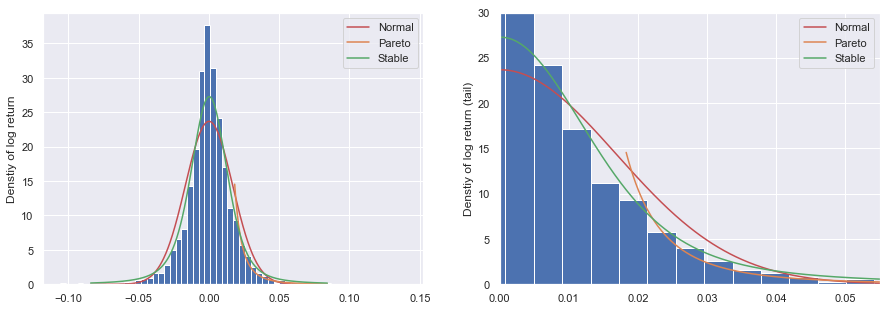

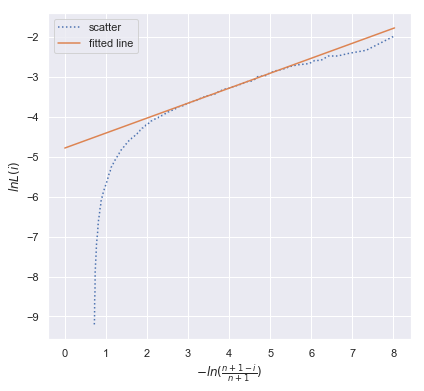

In [16]:
# Get Pareto VaR
toy = -1 * np.array(log_returns['BP.L'])
pvar = VaR(toy,"Pareto",0.99,252)
pvar.get_VaR()

# give a quick look on the toy stock
# draw the density plot the data
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
plt.subplot(1,2,1)
ne = Normal_Estimator(toy)
ne.fit_normal()
mu = ne.mean
sigma = ne.sigma
x = np.linspace(mu - 5 * sigma, mu + 5 * sigma, 1000)
(-1 * log_returns['BP.L']).hist(bins = 60,normed = True)
plt.plot(x, mlab.mlab.normpdf(x, mu, sigma), label= 'Normal', color = 'r')

pe = Pareto_Estimator(toy,0.9)
pe.fit_pareto()

x = np.linspace(mu - 5 * sigma, mu + 5 * sigma, 1000)
y = pe.pdf(x)
plt.plot(x, y, label = 'Pareto')

s_d = np.array(pd.read_csv('Stable_density.csv')['X1'])
x = np.linspace(mu - 5 * sigma, mu + 5 * sigma, 1000)
plt.plot(x, s_d, label = 'Stable')
plt.ylabel('Denstiy of log return')
plt.legend()

# draw the tail of log losses
plt.subplot(1,2,2)
x = np.linspace(mu - 5 * sigma, mu + 5 * sigma, 1000)
(-1 * log_returns['BP.L']).hist(bins = 60, normed = True)
plt.plot(x, mlab.mlab.normpdf(x, mu, sigma), label= 'Normal', color = 'r')
x = np.linspace(mu - 5 * sigma, mu + 5 * sigma, 1000)
y = pe.pdf(x)
plt.plot(x, y, label = 'Pareto')
x = np.linspace(mu - 5 * sigma, mu + 5 * sigma, 1000)
plt.plot(x, s_d, label = 'Stable')
plt.xlim((0.0, 0.055))
plt.ylim((0, 30))
plt.ylabel('Denstiy of log return (tail)')
plt.legend()

pe.pareto_plot()
plt.subplots_adjust(hspace=1., wspace=0.5)
plt.show()


Their performances on the toy asset were slightly better. From the tail distribution, we saw that the density functions of both stable and pareto decay much slower than normal distribution. The ln-ln plot of the rank losses also justified using pareto law to approximate the tail of toy asset. We can look forward to their performances on whole data set.

In [17]:
# read stable data from csv
S_VaR = pd.read_csv('Stable_VaR.csv', index_col = 'Date') / 100

S_VaR = np.array(S_VaR)
s_upper, s_lower, s_avgpor = np.zeros(S_VaR.shape[1]), np.zeros(S_VaR.shape[1]), np.zeros(S_VaR.shape[1])

for i in range(S_VaR.shape[1]):
    negl_return = -1 * np.array(log_returns.iloc[:, i])
    u, l, a = Back_Testing(negl_return, S_VaR[:, i], 0.01)
    s_upper[i], s_lower[i], s_avgpor[i] = u, l, a

print('Average fitting time per stock (Stable): 60 seconds (Obtained from R)')

Average fitting time per stock (Stable): 60 seconds (Obtained from R)


In [18]:
# Let's start massive data calculation!
P_VaR, P_tail, P_C = [], [], []
count = 0
tic = 0
for col in log_returns:
    count += 1
    negl_return = -1 * np.array(log_returns[col])
    
    # Get Pareto VaR
    pvar = VaR(negl_return,"Pareto",0.99,252)
    pvar.get_VaR()
    tic += pvar.time
    if count%5 == 0:
        print("Fitting time need for current stock: %.5f seconds" % pvar.time)
    P_VaR.append(pvar.fitted_var)
    # Get tail index and const of pareto & stable
    P_tail.append(pvar.tail_index)
    P_C.append(pvar.C_st)
 
print("Average fitting time per stock (Pareto): %.5f seconds" % (tic / nbTickers))
P_VaR, P_tail, P_C = np.array(P_VaR).T, np.array(P_tail).T, np.array(P_C).T # of shape N * P (stock num)

Fitting time need for current stock: 0.00024 seconds
Fitting time need for current stock: 0.00024 seconds
Fitting time need for current stock: 0.00026 seconds
Fitting time need for current stock: 0.00025 seconds
Fitting time need for current stock: 0.00027 seconds
Fitting time need for current stock: 0.00024 seconds
Fitting time need for current stock: 0.00025 seconds
Fitting time need for current stock: 0.00024 seconds
Fitting time need for current stock: 0.00024 seconds
Average fitting time per stock (Pareto): 0.00025 seconds


These two models are more complicated in the settings, especially for stable distribution. It requires maximum likelihood to estimate four parameters, which could be very time consuming. But considering in real life one only need to repeat the calculation once daily, one minute per stock is still acceptable. Pareto is faster as shown by the time tics.

In [19]:
# the i-th element of p_upper is the i-th stock's upper bound of CI, the rest likewise
p_upper, p_lower, p_avgpor = np.zeros(P_VaR.shape[1]), np.zeros(P_VaR.shape[1]), np.zeros(P_VaR.shape[1])

for i in range(P_VaR.shape[1]):
    negl_return = -1 * np.array(log_returns.iloc[:, i])
    # Backtesting Pareto
    u, l, a = Back_Testing(negl_return, P_VaR[:, i], 0.01)
    p_upper[i], p_lower[i], p_avgpor[i] = u, l, a

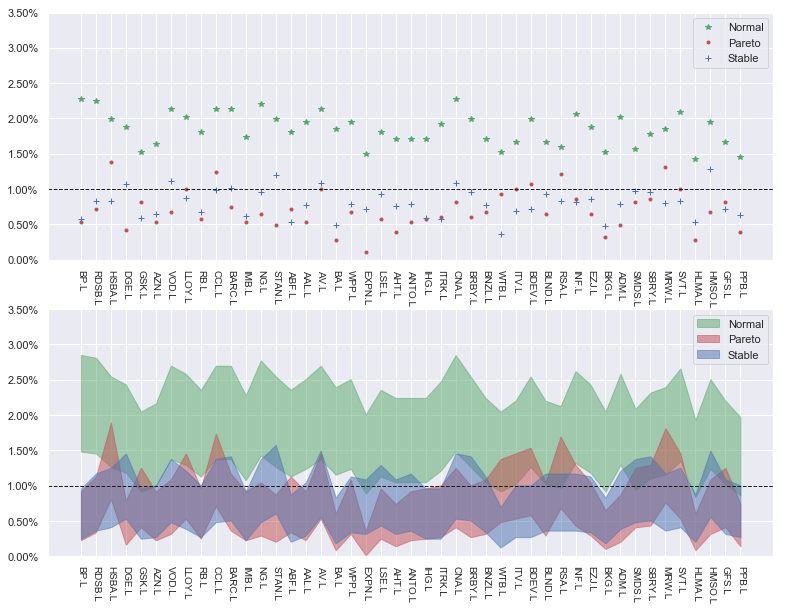

In [21]:
# draw the 99% CI of VaR given chosen stocks
import matplotlib.ticker as mtick
plt.subplots(figsize = (13, 10))
ax1 = plt.subplot(2, 1, 2)
ax1 = plt.gca()
fmt='%.2f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax1.yaxis.set_major_formatter(yticks)
ax1.fill_between(range(len(n_avgpor)), n_upper * 100, n_lower * 100, color='g', alpha=.5, label = 'Normal')
ax1.fill_between(range(len(p_avgpor)), p_upper * 100, p_lower * 100, color='r', alpha=.5, label = 'Pareto')
ax1.fill_between(range(len(s_avgpor)), s_upper * 100, s_lower * 100, color='b', alpha=.5, label = 'Stable')
ax1.axhline(y = 1, xmin = 0, xmax = 4, linewidth=1, color = 'k', linestyle="--")
plt.xticks(np.arange(len(n_avgpor)), list(log_returns))
plt.ylim((0, 3.5))
plt.xticks(rotation=270, fontsize = 10)
plt.legend()

# draw average porportions
ax2 = plt.gca()
ax2 = plt.subplot(2, 1, 1)
ax2.plot(n_avgpor * 100, 'g*', label = 'Normal', linewidth = 30)
ax2.plot(p_avgpor * 100, 'r.', label = 'Pareto', linewidth = 30)
ax2.plot(s_avgpor * 100, 'b+', label = 'Stable', linewidth = 30)
ax2.axhline(y = 1, xmin = 0, xmax = 4, linewidth = 1, color = 'k', linestyle="--")
plt.xticks(np.arange(len(n_avgpor)), listExtractTickers)
fmt='%.2f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax2.yaxis.set_major_formatter(yticks)
plt.ylim((0, 3.5))
plt.xticks(rotation=270, fontsize = 10)
plt.legend()
plt.show()

The result comes in line with our expectations. Compared with normal distribution, stable and parato are more capable of defending against risk: average proportions of exceedances were much lower. However, another problem aroused. The estimation of VaR based on Pareto distributions often overestimates the VaR. Though the VaR based on stable distributions perform slightly better than that based on Pareto distributions, it is still an overestimation.

In [22]:
def fill_return_mean(X):

    n,p = X.shape

    for j in range(p):
        ind = np.where(~np.isnan(X[:, j]))[0]
        m = X[ind,j].mean()
        ind = np.where(np.isnan(X[:, j]))[0]
        X[ind, j] = m

    return X

In [24]:
S_tail = np.array(pd.read_csv('Stable_alpha.csv', index_col = 'Date'))
S_C = np.array(pd.read_csv('Stable_Cst.csv', index_col = 'Date'))
S_gamma = np.array(pd.read_csv('Stable_gamma.csv', index_col = 'Date')) / 100
S_tail, S_C, S_gamma = fill_return_mean(S_tail), fill_return_mean(S_C), fill_return_mean(S_gamma)


from scipy.signal import *
S_tail, S_C, S_gamma = medfilt(S_tail), medfilt(S_C), medfilt(S_gamma)

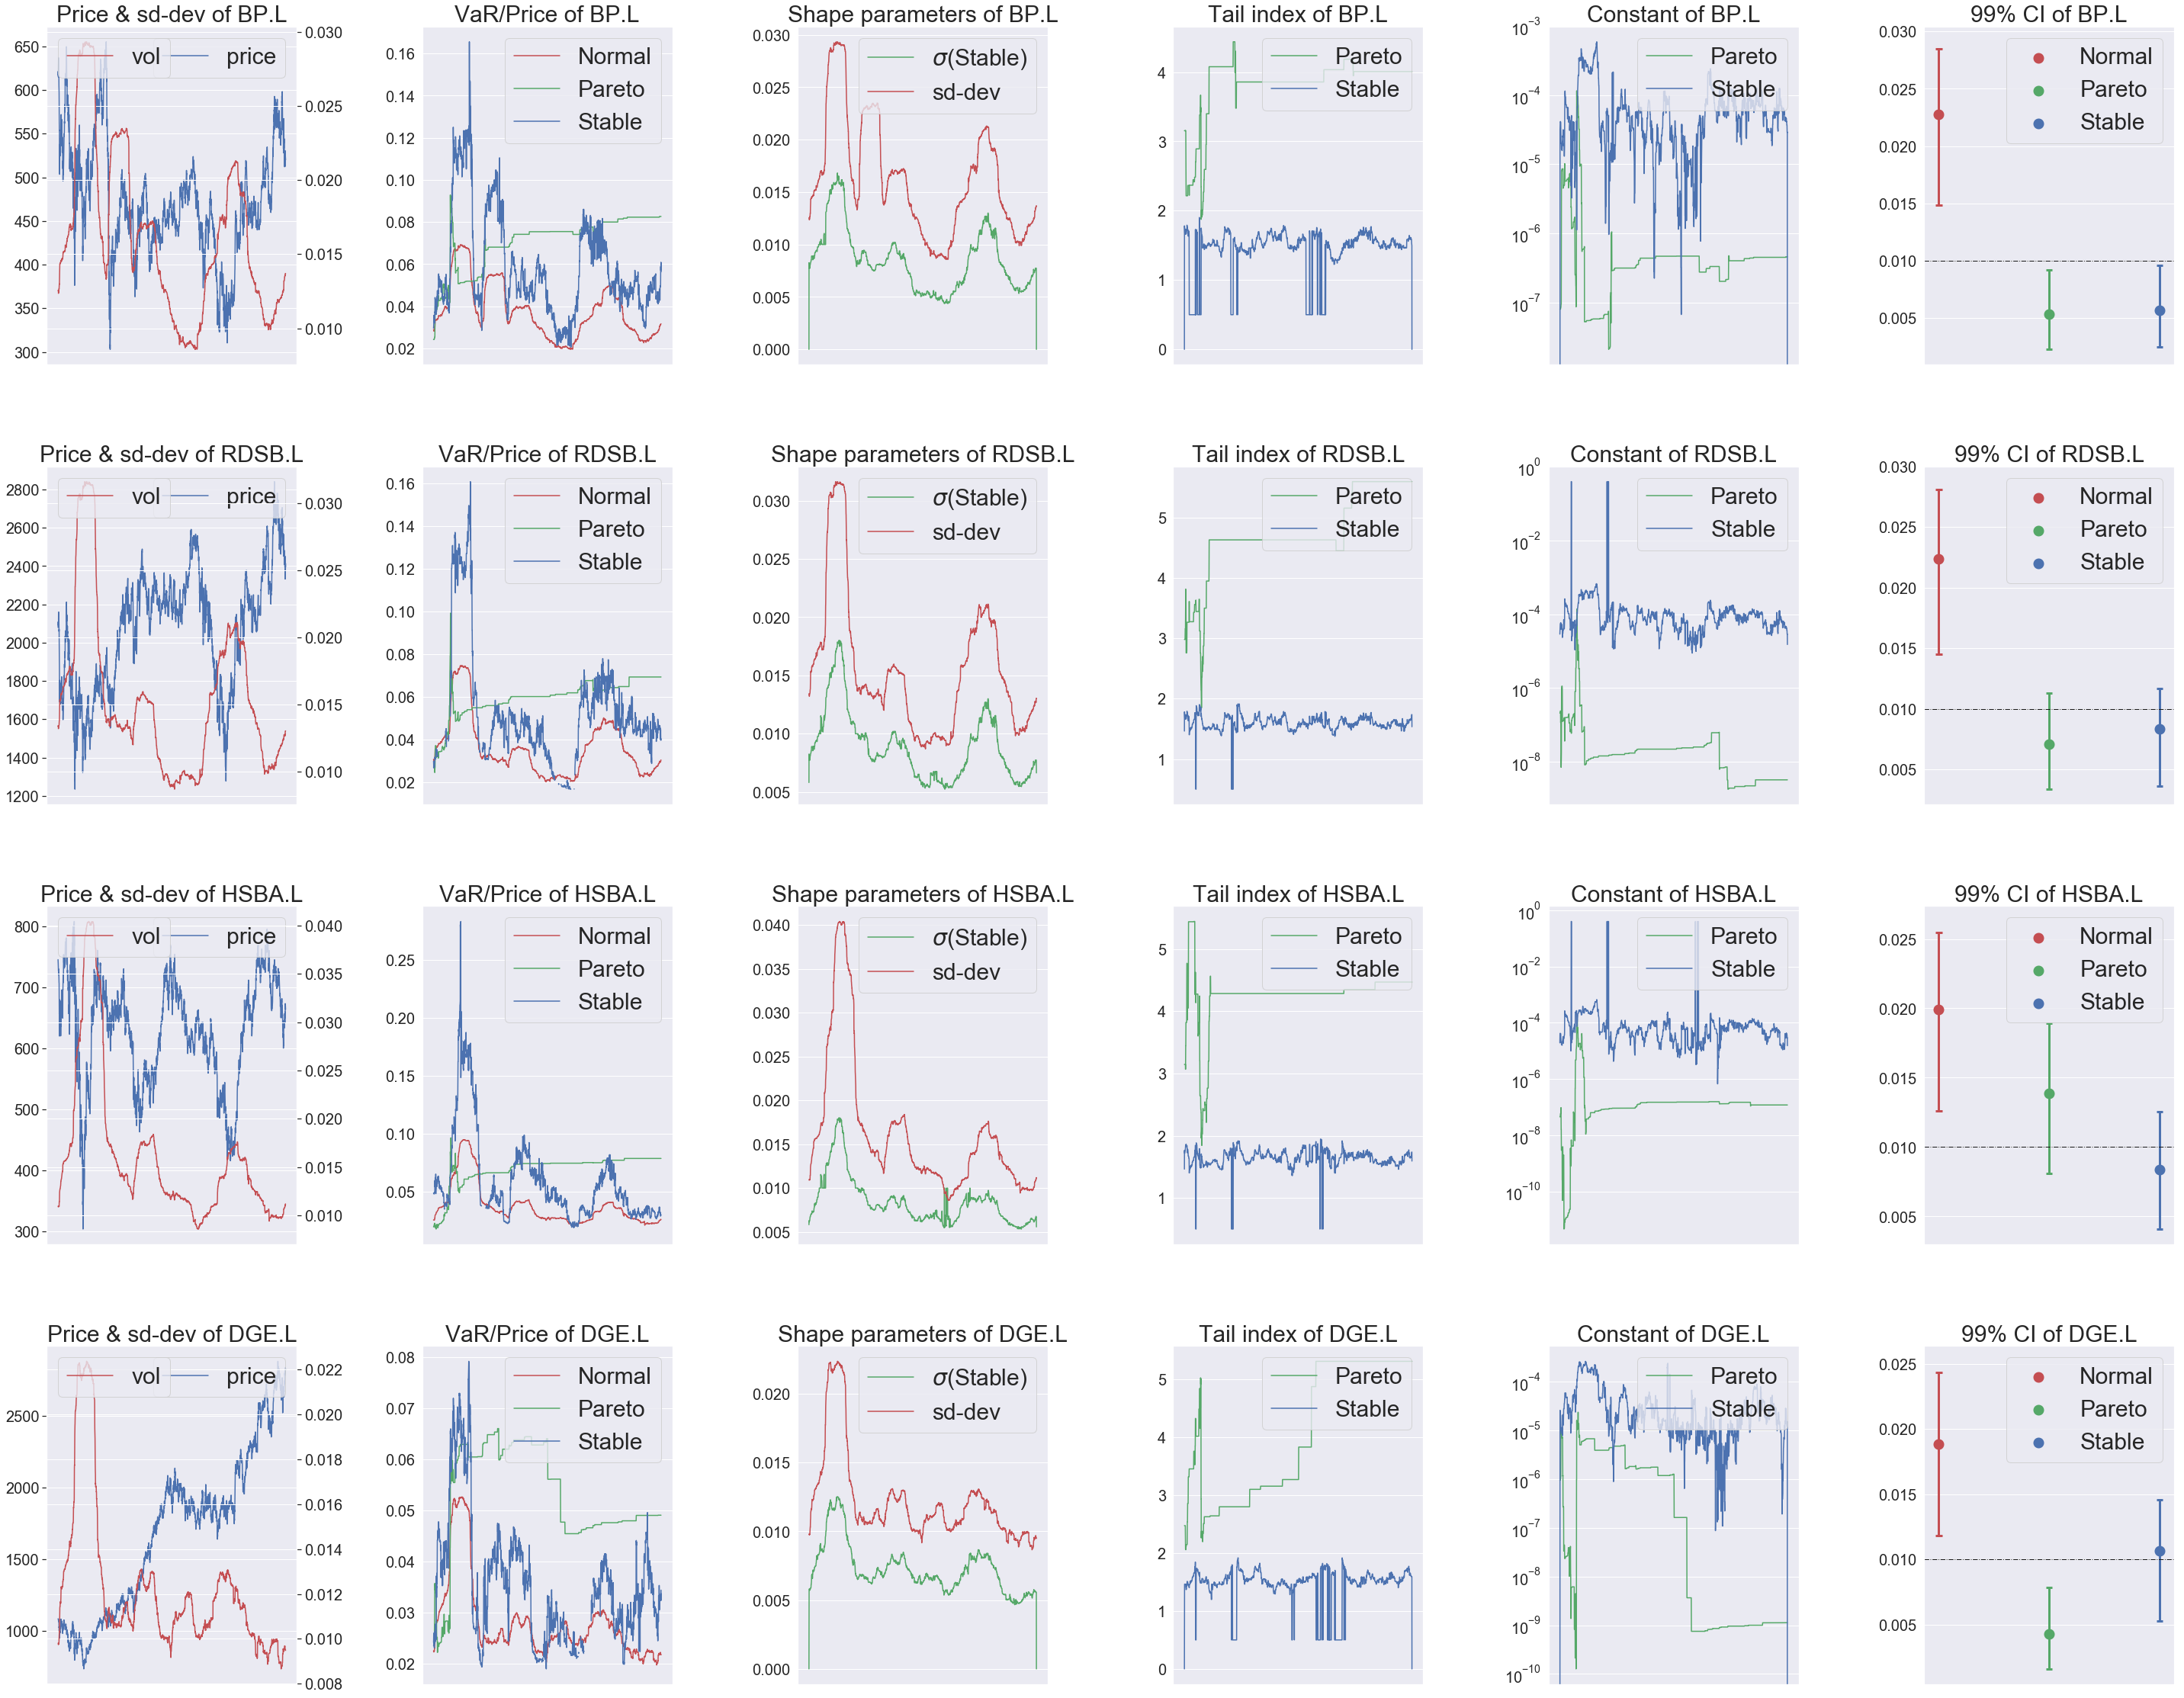

In [25]:
import matplotlib.ticker as tickers
nb = 4 # number of stocks displayed
fig, axs = plt.subplots(nrows = nb, ncols = 6, figsize = (50, 40))
for i in range(nb):
    ticker = listExtractTickers[i]
    
    # draw evolution of price and std
    ax1 = plt.subplot(nb, 6, 6*i+1)
    sd = [np.std(log_returns[ticker][i:i + 252], ddof = 1) for i in range(len(df[ticker]) - 252)]
    ax1.plot(np.array(df[ticker][252:]), label = 'price')
    plt.yticks(fontsize = 20)
    plt.legend(fontsize = 30, loc = 1)
    ax2 = ax1.twinx()
    ax2.plot(sd, 'r', label = 'vol')
    plt.xticks([])
    plt.yticks(fontsize = 20)
    plt.title('Price & sd-dev of %s'%ticker, fontsize=30)
    plt.legend(fontsize = 30, loc = 2)
    
    # draw the evolution of VaR/Price
    plt.subplot(nb, 6, 6*i+2)
    plt.plot(N_VaR[:, i], 'r', label = 'Normal')
    plt.plot(P_VaR[:, i], 'g', label = 'Pareto')
    plt.plot(S_VaR[:, i], 'b', label = 'Stable')
    plt.xticks([])
    plt.yticks(fontsize = 20)
    plt.title('VaR/Price of %s'%ticker, fontsize=30)
    plt.legend(fontsize = 30)
    
    # draw the evolution of shape param
    plt.subplot(nb, 6, 6*i+3)
    plt.plot(S_gamma[:, i], 'g', label = '$\sigma$(Stable)')
    plt.plot(sd, 'r', label = 'sd-dev')
    plt.xticks([])
    plt.yticks(fontsize = 20)
    plt.title('Shape parameters of %s'%ticker, fontsize=30)
    plt.legend(fontsize = 30)
    
    # draw the evolution of tail index
    plt.subplot(nb, 6, 6*i+4)
    plt.plot(P_tail[:, i], label = 'Pareto', color = 'g')
    plt.plot(S_tail[:, i], label = 'Stable', color = 'b')
    plt.xticks([])
    plt.yticks(fontsize = 20)
    plt.title('Tail index of %s'%ticker, fontsize=30)
    plt.legend(fontsize = 30, loc = 1)
    
    # draw the evolution of the model const
    ax = plt.subplot(nb, 6, 6*i+5)
    ax.plot(P_C[:, i], label = 'Pareto', color = 'g')
    ax.plot(S_C[:, i], label = 'Stable', color = 'b')
    plt.xticks([])
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(tickers.LogLocator(base=10.0))
    plt.yticks(fontsize = 20)
    plt.title('Constant of %s'%ticker, fontsize=30)
    plt.legend(fontsize = 30, loc = 1)
    
    # draw the CI of three model VaR
    plt.subplot(nb, 6, 6*i+6)
    plt.scatter([1], [n_avgpor[i]], linewidth = 8, color='r', label = 'Normal')
    plt.scatter([2], [p_avgpor[i]], linewidth = 8, color='g', label = 'Pareto')
    plt.scatter([3], [s_avgpor[i]], linewidth = 8, color='b', label = 'Stable')
    plt.vlines([1], n_lower[i], n_upper[i] ,'r',linewidths = 3)
    plt.hlines(n_lower[i],0.97,1.03,'r',linewidths = 3)
    plt.hlines(n_upper[i],0.97,1.03,'r',linewidths = 3)
    plt.vlines([2], p_lower[i], p_upper[i] ,'g',linewidths = 3)
    plt.hlines(p_lower[i],1.97,2.03,'g',linewidths = 3)
    plt.hlines(p_upper[i],1.97,2.03,'g',linewidths = 3)
    plt.vlines([3], s_lower[i], s_upper[i] ,'b',linewidths = 3)
    plt.hlines(s_lower[i],2.97,3.03,'b',linewidths = 3)
    plt.hlines(s_upper[i],2.97,3.03,'b',linewidths = 3)
    plt.axhline(y = 0.01, linewidth = 1, color = 'k', linestyle="-.")
    plt.title('99%% CI of %s'%ticker, fontsize=30)
    plt.yticks(fontsize = 20)
    plt.legend(fontsize = 30)
    plt.xticks([])
    
    
plt.subplots_adjust(hspace=.3, wspace=0.5)
plt.show()

Following the same method as discussed in the heavy-tails behavior studies[1], we come to a similar conclusion: even though there are some uncertainties when using power laws to estimate the parameters compared with Gaussian and stable, the opposite fluctuations are offsetting each other, which actually leading to a pretty good VaR and backtesting result.

## 5. Hyperbolic Distributions

In order to get more precise estimation, we implemented the Hyperbolic method to fit the data based on R.
The hyperbolic distribution is a continuous probability distribution defined as the normal variance-mean mixture where the mixing distribution is the generalized inverse Gaussian distribution (GIG ($\lambda = 1, \chi, \psi$)), a class of distributions that generalizes the Gaussian distribution. More precisely, it can be described by five parameters $\theta = (\lambda, \alpha, \beta, \delta, \mu)$ and its pdf is given by:

$$ f_{GIG}(x)=\frac{(\psi/\chi)^{\lambda/2}}{2K_{\lambda}(\sqrt{\chi\psi})}x^{\lambda-1}e^{-\frac{1}{2}({\chi}x^{-1}+{\psi}x)}, \quad\quad x>0 $$

where:

$$ K_{\lambda} (t) = \frac{1}{2} \int^\infty_{0} x^{\lambda-1}e^{-\frac{1}{2}t(x+x^{-1})}dx,   \quad\quad t>0 $$


#### Why hyperbolic?

 The motivation of using this distribution is that the hyperbolic law provides the possibility of modeling heavier tails than the Normal, since its log-density forms a hyperbola while that of the Normal is a parabola, but lighter than the stable, as the following picture shows.[2]

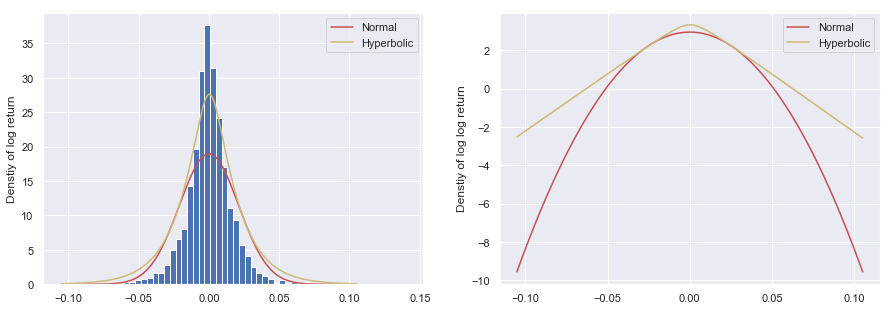

In [26]:
# pick up one stock and give a quick view
toy = -1 * np.array(log_returns['BP.L'][0:700])

# Get Normal VaR
nvar = VaR(toy,"Normal",0.99,252)
nvar.get_VaR()

# give a quick look of the fitted result
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
plt.subplot(1,2,1)
ne = Normal_Estimator(toy)
ne.fit_normal()
mu = ne.mean
sigma = ne.sigma
x = np.linspace(mu - 5 * sigma, mu + 5 * sigma, 1000)
(-1 * log_returns['BP.L']).hist(bins = 60, normed = True)
plt.plot(x, mlab.mlab.normpdf(x, mu, sigma), label= 'Normal', color = 'r')
h_d = np.array(pd.read_csv('Ghyp_density.csv')['X1'])
plt.plot(x, h_d, label= 'Hyperbolic', color = 'y')
plt.legend()
plt.ylabel('Denstiy of log return')

plt.subplot(1,2,2)
plt.plot(x, np.log(mlab.mlab.normpdf(x, mu, sigma)), label= 'Normal', color = 'r')
plt.plot(x, np.log(h_d), label= 'Hyperbolic', color = 'y')
plt.ylabel('Denstiy of log log return')
plt.legend()
plt.show()

From the probability density function one can see that the distribution decreases exponentially, which is more slowly than the normal distribution. Therefore it is more suitable for modelling heavy tails.

In [27]:
# run in R, read from csv file
H_VaR = pd.read_csv('Hyperbolic_VaR99.csv', index_col = 'Date')
print('Average fitting time per stock (Hyperbolic): 52 seconds (Obtained from R)')

Average fitting time per stock (Hyperbolic): 52 seconds (Obtained from R)


In [28]:
H_VaR = np.array(H_VaR)
h_upper, h_lower, h_avgpor = np.zeros(H_VaR.shape[1]), np.zeros(H_VaR.shape[1]), np.zeros(H_VaR.shape[1])

for i in range(H_VaR.shape[1]):
    negl_return = -1 * np.array(log_returns.iloc[:, i])
    # Backtesting Hyperbolic
    u, l, a = Back_Testing(negl_return, H_VaR[:, i], 0.01)
    h_upper[i], h_lower[i], h_avgpor[i] = u, l, a

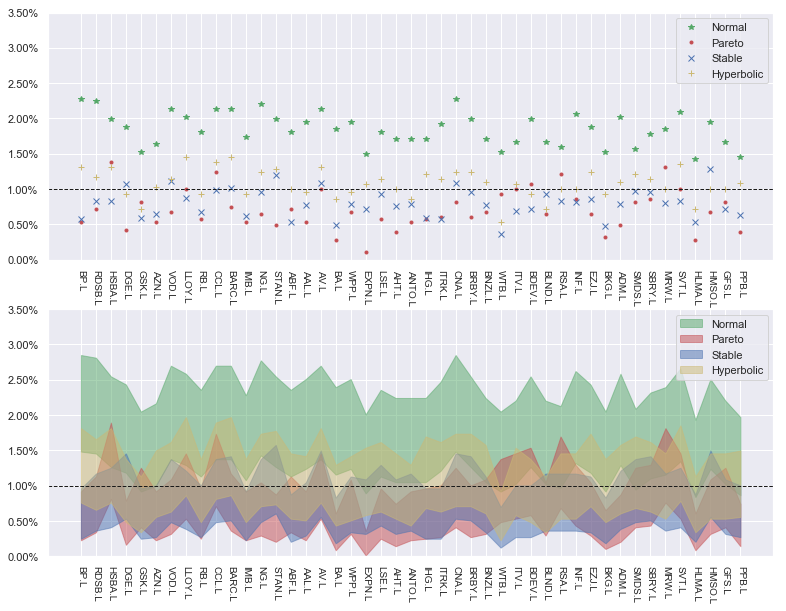

In [29]:
# draw the 99% CI of VaR given chosen stocks
import matplotlib.ticker as mtick
plt.subplots(figsize = (13, 10))
ax1 = plt.subplot(2, 1, 2)
ax1 = plt.gca()
fmt='%.2f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax1.yaxis.set_major_formatter(yticks)
ax1.fill_between(range(len(n_avgpor)), n_upper * 100, n_lower * 100, color='g', alpha=.5, label = 'Normal')
ax1.fill_between(range(len(p_avgpor)), p_upper * 100, p_lower * 100, color='r', alpha=.5, label = 'Pareto')
ax1.fill_between(range(len(s_avgpor)), s_upper * 100, s_lower * 100, color='b', alpha=.5, label = 'Stable')
ax1.fill_between(range(len(h_avgpor)), h_upper * 100, h_lower * 100, color='y', alpha=.5, label = 'Hyperbolic')
ax1.axhline(y = 1, xmin = 0, xmax = 4, linewidth=1, color = 'k', linestyle="--")
plt.xticks(np.arange(len(n_avgpor)), list(log_returns))
plt.ylim((0, 3.5))
plt.xticks(rotation=270, fontsize = 10)
plt.legend()

# draw average porportions
ax2 = plt.gca()
ax2 = plt.subplot(2, 1, 1)
ax2.plot(n_avgpor * 100, 'g*', label = 'Normal', linewidth = 30)
ax2.plot(p_avgpor * 100, 'r.', label = 'Pareto', linewidth = 30)
ax2.plot(s_avgpor * 100, 'bx', label = 'Stable', linewidth = 30)
ax2.plot(h_avgpor * 100, 'y+', label = 'Hyperbolic', linewidth = 30)
ax2.axhline(y = 1, xmin = 0, xmax = 4, linewidth = 1, color = 'k', linestyle="--")
plt.xticks(np.arange(len(n_avgpor)), listExtractTickers)
fmt='%.2f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax2.yaxis.set_major_formatter(yticks)
plt.ylim((0, 3.5))
plt.xticks(rotation=270, fontsize = 10)
plt.legend()
plt.show()

The result from the backtesting and confidence intervals proved the preciseness of this method - the most VaRs estimated by Hyperbolic model are close to the real value which means it is a proper estimation.

# 6. Conclusion

The properties presented above imply that the Hyperbolic distribution is an appealing process to model the stock returns. The tail behavior of the Hyperbolic Distribution implies that the hyperbolic market model may be successfully employed to improve financial derivatives pricing models and the estimation of market risk using VaR methodology. Whereas the normal distribution is not suitable for dealing with extreme events since it tends to underestimate the risk of extreme events.

The last figure gives the result of backtesting and confidence intervals for four different model on 45 given stocks. In terms of the result of backtesting, the VaR driven from Normal distribution (close to 98%) is often smaller than the real value which means the tail of Normal distribution is too thin to fit the real data; The VaRs resulted from Pareto and Stable distribution (close to 99.5%) respectively are often larger than 99% which means the tails of them are too fat to fit the real data. However, Hyperbolic method estimates the most proper VaRs which are close to the target value 99%. 

As a result, we can conclude that the model based on the Hyperbolic distributions provides the best results in terms of backtesting.


# Reference

[1] N. Champagnat, M. Deaconu, A. Lejay, N. Navet, S. Boukherouaa. "An empirical analysis of heavy-tails behavior of financial data: The case for power laws". 2013. <hal00851429>

[2] S. Borak, A. Misiorek, R. Weron. "Models for Heavy-tailed Asset Returns". 2010. <ISSN 1860-5664>

[3] Mikko Pakkanen. "Notes on risk measures"

[4] Wikipedia available at https://en.wikipedia.org/wiki/Generalised_hyperbolic_distribution. [14/12/2018]


# Appendix A - R code for Stable Distribution

library(stabledist)
library(StableEstim)
library(fBasics)
library(MASS)

Data <- read.csv("data.csv")
Data <- as.data.frame(Data)
Dates <- timeDate(as.character(Data$Date))
tickers = c('BP.L','RDSB.L','HSBA.L','DGE.L','GSK.L','AZN.L','VOD.L','LLOY.L','RB.L','CCL.L',
            'BARC.L','IMB.L','NG.L','STAN.L','ABF.L','AAL.L','AV.L','BA.L','WPP.L','EXPN.L',
            'LSE.L','AHT.L','ANTO.L','IHG.L','ITRK.L','CNA.L','BRBY.L','BNZL.L','WTB.L','ITV.L','BDEV.L',
            'BLND.L','RSA.L','INF.L','EZJ.L','BKG.L','ADM.L','SMDS.L','SBRY.L','MRW.L','SVT.L',
            'HLMA.L','HMSO.L','GFS.L','PPB.L')
header = c('Date','BP.L','RDSB.L','HSBA.L','DGE.L','GSK.L','AZN.L','VOD.L','LLOY.L','RB.L','CCL.L',
           'BARC.L','IMB.L','NG.L','STAN.L','ABF.L','AAL.L','AV.L','BA.L','WPP.L','EXPN.L',
           'LSE.L','AHT.L','ANTO.L','IHG.L','ITRK.L','CNA.L','BRBY.L','BNZL.L','WTB.L','ITV.L','BDEV.L',
           'BLND.L','RSA.L','INF.L','EZJ.L','BKG.L','ADM.L','SMDS.L','SBRY.L','MRW.L','SVT.L',
           'HLMA.L','HMSO.L','GFS.L','PPB.L')

varmatrix = data.frame(matrix(vector(), 2812, 46,
                              dimnames=list(c(), header)),
                       stringsAsFactors=F)
esa_matrix = data.frame(matrix(vector(), 2812, 46,
                               dimnames=list(c(), header)),
                        stringsAsFactors=F)
esb_matrix = data.frame(matrix(vector(), 2812, 46,
                               dimnames=list(c(), header)),
                        stringsAsFactors=F)
esc_matrix = data.frame(matrix(vector(), 2812, 46,
                               dimnames=list(c(), header)),
                        stringsAsFactors=F)
esd_matrix = data.frame(matrix(vector(), 2812, 46,
                               dimnames=list(c(), header)),
                        stringsAsFactors=F)
cst_matrix = data.frame(matrix(vector(), 2812, 46,
                               dimnames=list(c(), header)),
                        stringsAsFactors=F)

varmatrix[,1] = Dates[253:3064]
esa_matrix[,1] = Dates[253:3064]
esb_matrix[,1] = Dates[253:3064]
esc_matrix[,1] = Dates[253:3064]
esd_matrix[,1] = Dates[253:3064]
cst_matrix[,1] = Dates[253:3064]

i = 1
while(i<=4){
  st = timeSeries(Data[tickers[i]],Dates)
  st.return = -returns(st,percentage=FALSE)
  j = 1
  fitted_var = c(0)
  esa = c(0)
  esb = c(0)
  esc = c(0)
  esd = c(0)
  cst = c(0)
  while (j <= length(st.return) - 252){
    k <- McCullochParametersEstim(st.return[j:(j+252)])
    es_a <- k[["alpha"]]
    es_b <- k[["beta"]]
    es_c <- k[["gamma"]]
    es_d <- k[["delta"]]
    esa[j] = es_a
    esb[j] = es_b
    esc[j] = es_c
    esd[j] = es_d
    cst[j] = (esc[j] ^ esa[j]) * sin(pi * esa[j] /2) * gamma(esa[j]) / pi * (1-esb[j])
    fitted_var[j] = qstable(0.99,alpha = es_a,beta = es_b,gamma = es_c,delta = es_d)
    j = j + 1
  }
  fitted_var[fitted_var>1559] = NA
  varmatrix[,i+1] = fitted_var
  esa_matrix[,i+1] = esa
  esb_matrix[,i+1] = esb
  esc_matrix[,i+1] = esc
  esd_matrix[,i+1] = esd
  cst_matrix[,i+1] = cst
  print(tickers[i])
  i = i + 1
}

write.csv(varmatrix,"result.csv",row.names = FALSE)
write.csv(esa_matrix,"Stable_alpha.csv",row.names = FALSE)
write.csv(esb_matrix,"Stable_beta.csv",row.names = FALSE)
write.csv(esc_matrix,"Stable_gamma.csv",row.names = FALSE)
write.csv(esd_matrix,"Stable_delta.csv",row.names = FALSE)
write.csv(cst_matrix,"Stable_Cst.csv",row.names = FALSE)

Stabledata <- read.csv("xaxis.csv")
Stabledata <- as.data.frame(Stabledata)
st = timeSeries(Data[tickers[1]],Dates)
st.return = -returns(st,percentage=FALSE)
k <- McCullochParametersEstim(st.return[1:700])
es_a <- k[["alpha"]]
es_b <- k[["beta"]]
es_c <- k[["gamma"]]
es_d <- k[["delta"]]
i = 1
while(i<=1000){
  Stabledata$X1[i] = dstable(Stabledata$X0[i],es_a,es_b,es_c,es_d)
  i = i+1
}

# Appendix B - R code for Hyperbolic Distribution

library(ghyp)

Data <- read.csv("data.csv")
Dates <- timeDate(as.character(Data$Date))
tickers = c('BP.L','RDSB.L','HSBA.L','DGE.L','GSK.L','AZN.L','VOD.L','LLOY.L','RB.L','CCL.L',
            'BARC.L','IMB.L','NG.L','STAN.L','ABF.L','AAL.L','AV.L','BA.L','WPP.L','EXPN.L',
            'LSE.L','AHT.L','ANTO.L','IHG.L','ITRK.L','CNA.L','BRBY.L','BNZL.L','WTB.L','ITV.L','BDEV.L',
            'BLND.L','RSA.L','INF.L','EZJ.L','BKG.L','ADM.L','SMDS.L','SBRY.L','MRW.L','SVT.L',
            'HLMA.L','HMSO.L','GFS.L','PPB.L')
header = c('Date','BP.L','RDSB.L','HSBA.L','DGE.L','GSK.L','AZN.L','VOD.L','LLOY.L','RB.L','CCL.L',
           'BARC.L','IMB.L','NG.L','STAN.L','ABF.L','AAL.L','AV.L','BA.L','WPP.L','EXPN.L',
           'LSE.L','AHT.L','ANTO.L','IHG.L','ITRK.L','CNA.L','BRBY.L','BNZL.L','WTB.L','ITV.L','BDEV.L',
           'BLND.L','RSA.L','INF.L','EZJ.L','BKG.L','ADM.L','SMDS.L','SBRY.L','MRW.L','SVT.L',
           'HLMA.L','HMSO.L','GFS.L','PPB.L')


varmatrix95 = data.frame(matrix(vector(), 2812, 46,
                       dimnames=list(c(), header)),
                stringsAsFactors=F)

varmatrix95[,1] = Dates[253:3064]

varmatrix99 = data.frame(matrix(vector(), 2812, 46,
                              dimnames=list(c(), header)),
                       stringsAsFactors=F)

varmatrix99[,1] = Dates[253:3064]
timelist = c(0)

i = 1
while (i <= 45){
  hp = timeSeries(Data[tickers[i]],Dates)
  #hp = Data[tickers[i]]
  hp.return = -returns(hp,percentage=FALSE)
  j = 1
  fitted_var95 = c(0)
  fitted_var99 = c(0)
  start = Sys.time()
  while (j <= length(hp.return) - 252){
    hd.fit <- fit.hypuv(hp.return[j:(j+252)],opt.pars = c(alpha.bar = FALSE),symmetric = F,silent=T)
    hist(hd.fit)
    fitted_var95[j] = qghyp(0.95, hd.fit, method = c("integration", "splines"), spline.points = 200, subdivisions = 200)
    fitted_var99[j] = qghyp(0.99, hd.fit, method = c("integration", "splines"), spline.points = 200, subdivisions = 200)
    j = j + 1
  }
  end = Sys.time()
  timelist[i] = end - start
  varmatrix95[,(i+1)] = fitted_var95
  varmatrix99[,(i+1)] = fitted_var99
  print(tickers[i])
  i = i + 1
}